# IPDA Multi_tracking

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Ellipse
import io
from PIL import Image as PILImage
from IPython.display import Image as IPImage, display
import matplotlib.transforms as transforms
np.set_printoptions(precision=2)
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image as IPImage
import matplotlib.cm as cm

## Simulace and clatter

In [ ]:
def create_simulation(dt, q, r, targets_initial_states, steps=100):
    """
    Creates a simulation of multiple targets movement and measurements.

    Parameters:
    dt - time step
    q - process noise parameter
    r - measurement noise parameter
    targets_initial_states - list of initial states [x, y, vx, vy] for each target
    steps - number of simulation steps

    Returns:
    x_targets - actual states for all targets
    z_targets - measurements for all targets
    A, H, Q, R - model matrices
    """

    # Create model matrices
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1,  0],
                  [0, 0, 0,  1]])

    Q = q**2 * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                        [0,       dt**3/3, 0,       dt**2/2],
                        [dt**2/2, 0,       dt,      0      ],
                        [0,       dt**2/2, 0,       dt     ]])

    H = np.array([[1., 0, 0, 0],
                  [0., 1, 0, 0]])

    R = r**2 * np.eye(2)

    num_targets = len(targets_initial_states)
    x_targets = []
    z_targets = []

    # Generate data for each target
    for target_idx in range(num_targets):
        x = np.zeros((steps, 4))
        x[0] = targets_initial_states[target_idx]
        z = np.zeros((steps, 2))
        z[0] = H @ x[0] + mvn.rvs(cov=R)

        for k in range(1, steps):
            x[k] = A @ x[k-1] + mvn.rvs(cov=Q)
            z[k] = H @ x[k] + mvn.rvs(cov=R)

        x_targets.append(x)
        z_targets.append(z)

    return x_targets, z_targets, A, H, Q, R

def generate_clutter(lambda_value, x_min, x_max, y_min, y_max, steps):
    """
    Generates clutter (false measurements) based on Poisson distribution.

    Parameters:
    lambda_value - average number of clutter measurements per scan
    x_min, x_max, y_min, y_max - boundaries of the observation area
    steps - number of time steps

    Returns:
    clutter - list of clutter measurements for each time step
    """
    clutter = []
    area = (x_max - x_min) * (y_max - y_min)

    for _ in range(steps):
        # Number of clutter points following Poisson distribution
        num_clutter = np.random.poisson(lambda_value)

        # Generate uniformly distributed clutter points
        clutter_points = np.zeros((num_clutter, 2))
        if num_clutter > 0:
            clutter_points[:, 0] = np.random.uniform(x_min, x_max, num_clutter)
            clutter_points[:, 1] = np.random.uniform(y_min, y_max, num_clutter)

        clutter.append(clutter_points)

    return clutter

def simulate_detection_failures(z_targets, detection_probability, failure_intervals=None):
    """
    Simulates measurement failures with manual intervals for each track.

    Parameters:
    z_targets - list of target measurements
    detection_probability - probability of random detection failures
    failure_intervals - list of (start, end) tuples for each target's failure window

    Returns:
    missing_indices - list of time indices with missing measurements for each target
    """
    missing_indices = []

    for target_idx, z_target in enumerate(z_targets):
        steps = len(z_target)
        target_missing = []

        # Add random failures based on detection probability
        for t in range(steps):
            if np.random.rand() > detection_probability:
                target_missing.append(t)

        # Add manual failure intervals if provided
        if failure_intervals and target_idx < len(failure_intervals):
            start, end = failure_intervals[target_idx]
            # Ensure the failure window is within bounds
            start = max(0, min(start, steps-1))
            end = max(0, min(end, steps))
            # Add all frames in the interval
            target_missing.extend(range(start, end))

        # Remove duplicates and sort
        target_missing = sorted(list(set(target_missing)))
        missing_indices.append(target_missing)

    return missing_indices

def combine_measurements(z_targets, clutter, missing_indices):
    """
    Combines target measurements and clutter, accounting for detection failures.

    Parameters:
    z_targets - list of target measurements
    clutter - list of clutter measurements
    missing_indices - list of time indices with missing measurements for each target

    Returns:
    combined_z - combined measurements for each time step
    missing_z_flat - flat list of time steps with missing measurements (by target)
    missing_z_by_target - dictionary mapping time step to list of targets with missing measurements
    """
    steps = len(clutter)
    combined_z = []
    missing_z_flat = []

    # New structure to track which targets have missing measurements at each time step
    missing_z_by_target = {t: [] for t in range(steps)}

    for t in range(steps):
        # Start with clutter
        time_measurements = clutter[t].copy() if len(clutter[t]) > 0 else np.empty((0, 2))

        # Add target measurements if not missing
        for target_idx, z_target in enumerate(z_targets):
            if t not in missing_indices[target_idx] and t < len(z_target):
                # Add this target's measurement
                if len(time_measurements) == 0:
                    time_measurements = z_target[t].reshape(1, 2)
                else:
                    time_measurements = np.vstack((time_measurements, z_target[t]))
            else:
                missing_z_flat.append(t)
                missing_z_by_target[t].append(target_idx)

        combined_z.append(time_measurements)

    return combined_z, list(set(missing_z_flat)), missing_z_by_target

# IPDA

In [ ]:
def create_ipda_track(x_init, P_init, A, H, Q, R, P_D, P_S, gamma, track_id, r_0, confirm_threshold, delete_threshold, init_time):
    """
    Creates a new IPDA track as a dictionary.

    Parameters:
    x_init - initial state
    P_init - initial covariance matrix
    A - transition matrix
    H - measurement matrix
    Q - process noise covariance
    R - measurement noise covariance
    P_D - detection probability
    P_S - survival probability
    gamma - threshold for elliptical gate (chi-square)
    track_id - track ID
    r_0 - initial existence probability
    confirm_threshold - threshold for track confirmation
    delete_threshold - threshold for track deletion
    init_time - track initialization time
    """
    return {
        'x': x_init.copy(),
        'P': P_init.copy(),
        'A': A,
        'H': H,
        'Q': Q,
        'R': R,
        'P_D': P_D,
        'P_S': P_S,
        'gamma': gamma,
        'track_id': track_id,
        'r': r_0,              # Track existence probability
        'r_history': [r_0],    # History of track existence probabilities
        'confirm_t': confirm_threshold,
        'delete_t': delete_threshold,
        'init_time': init_time,
        'x_history': [x_init.copy()],
        'P_history': [P_init.copy()],
        'gate_meas_history': [[]],
        'is_confirmed': False,
        'is_active': True,
        'merged_with': None,   # Track ID this track was merged into, if any
        'merged_tracks': []    # List of track IDs merged into this track
    }

def is_active_track(track):
    """Checks if track is active"""
    return track['is_active']

def is_confirmed_track(track):
    """Checks if track is confirmed"""
    return track['is_confirmed']

def predict_ipda(track):
    """State prediction for IPDA"""
    # State prediction
    track['x'] = track['A'] @ track['x']
    track['P'] = track['A'] @ track['P'] @ track['A'].T + track['Q']

    # Existence probability prediction
    track['r'] = track['P_S'] * track['r']

    return track['x'], track['P'], track['r']

def gating_ipda(track, measurements, lambda_value, area):
    """
    Selects measurements that fall within the validation gate.

    Parameters:
    track - track dictionary
    measurements - array of measurements
    lambda_value - false measurement intensity
    area - scene area for proper lambda calculation

    Returns:
    valid_measurements - measurements that passed the gate
    valid_indices - indices of valid measurements
    """
    if len(measurements) == 0:
        return [], []

    # Measurement prediction
    z_pred = track['H'] @ track['x']

    # Innovation covariance
    S = track['H'] @ track['P'] @ track['H'].T + track['R']

    try:
        S_inv = np.linalg.inv(S)
    except np.linalg.LinAlgError:
        S_inv = np.linalg.pinv(S)

    valid_measurements = []
    valid_indices = []

    for i, z in enumerate(measurements):
        # Innovation
        nu = z - z_pred

        # Mahalanobis distance
        d_squared = nu.T @ S_inv @ nu

        # Check if measurement falls within validation gate
        if d_squared <= track['gamma']:
            valid_measurements.append(z)
            valid_indices.append(i)

    return np.array(valid_measurements) if valid_measurements else np.empty((0, 2)), valid_indices

def update_ipda(track, measurements, lambda_value, area):
    """
    IPDA filter update step.

    Parameters:
    track - track dictionary
    measurements - array of measurements
    lambda_value - false measurement intensity
    area - scene area for proper lambda calculation

    Returns:
    updated - whether filter was updated
    """
    # Measurement prediction
    z_pred = track['H'] @ track['x']

    # Innovation covariance
    S = track['H'] @ track['P'] @ track['H'].T + track['R']

    try:
        S_inv = np.linalg.inv(S)
    except np.linalg.LinAlgError:
        # Handle singular matrix
        S_inv = np.linalg.pinv(S)

    # Gating
    valid_measurements, valid_indices = gating_ipda(track, measurements, lambda_value, area)

    # Store measurements in gate
    track['gate_meas_history'].append(valid_measurements)

    # Number of measurements in validation region
    m_k = len(valid_measurements)

    # Calculate L_k for IPDA existence update
    if m_k == 0:
        L_k = (1 - track['P_D'])
    else:
        # Calculate likelihoods for all valid measurements
        sum_likelihoods = 0
        for z in valid_measurements:
            # Innovation
            nu = z - z_pred

            # Calculate likelihood with numerical stability
            try:
                exponent = -0.5 * nu.T @ S_inv @ nu
                determinant = np.linalg.det(S)
                if determinant <= 0:
                    determinant = np.finfo(float).eps

                likelihood = np.exp(exponent) / np.sqrt((2 * np.pi) ** len(nu) * determinant)
                sum_likelihoods += likelihood
            except:
                # Fallback if numerical issues occur
                sum_likelihoods += np.finfo(float).eps

        # Adjust lambda for area
        lambda_adjusted = lambda_value / area

        # Calculate L_k
        L_k = (1 - track['P_D']) + (track['P_D'] / lambda_adjusted) * sum_likelihoods

    # IPDA existence update
    r_prev = track['r']
    track['r'] = (L_k * r_prev) / ((1 - r_prev) + L_k * r_prev)

    # Store existence probability history
    track['r_history'].append(track['r'])

    # Update track confirmation status
    if track['r'] >= track['confirm_t'] and not track['is_confirmed']:
        track['is_confirmed'] = True

    # No valid measurements, only prediction
    if m_k == 0:
        # Store state and covariance history
        track['x_history'].append(track['x'].copy())
        track['P_history'].append(track['P'].copy())
        return False

    # Kalman gain
    W = track['P'] @ track['H'].T @ S_inv

    # Calculate data association probabilities (betas)
    betas = []
    likelihoods = []

    for z in valid_measurements:
        # Innovation
        nu = z - z_pred

        # Log-likelihood (for numerical stability)
        try:
            log_likelihood = -0.5 * nu.T @ S_inv @ nu - 0.5 * np.log(np.linalg.det(S)) - np.log(2 * np.pi)
            likelihood = np.exp(log_likelihood)
        except:
            # Fallback if numerical issues
            likelihood = np.finfo(float).eps

        # Bar-Shalom's scaled likelihood
        L = track['P_D'] * likelihood / (lambda_value / area)
        likelihoods.append(L)

    # Denominator for beta calculation
    denominator = (1 - track['P_D']) + sum(likelihoods)

    # Probability that no measurement is correct
    beta_0 = (1 - track['P_D']) / denominator

    # Probabilities for each measurement
    betas = [L / denominator for L in likelihoods]

    # If at least one valid measurement exists
    if m_k > 0:
        # Create combined innovation
        nu_combined = np.zeros(z_pred.shape)
        for i, z in enumerate(valid_measurements):
            nu_i = z - z_pred
            nu_combined += betas[i] * nu_i

        # State update
        track['x'] = track['x'] + W @ nu_combined

        # Calculate covariance after update
        P_c = (np.eye(track['P'].shape[0]) - W @ track['H']) @ track['P']

        P_tilde = np.zeros_like(track['P'])
        for i, z in enumerate(valid_measurements):
            v_i = z - z_pred
            P_tilde += betas[i] * (W @ (v_i.reshape(-1, 1) @ v_i.reshape(1, -1)) @ W.T)

        P_tilde -= W @ (nu_combined.reshape(-1, 1) @ nu_combined.reshape(1, -1)) @ W.T

        # Covariance update
        track['P'] = beta_0 * track['P'] + (1 - beta_0) * P_c + P_tilde

    # Store history
    track['x_history'].append(track['x'].copy())
    track['P_history'].append(track['P'].copy())

    return True

def should_delete_ipda(track):
    """
    Checks if track should be deleted based on existence probability.

    Returns:
    True if track should be deleted, False otherwise
    """
    # Check if existence probability dropped below deletion threshold
    if track['r'] < track['delete_t']:
        return True

    return False

def create_ipda_tracker(A, H, Q, R, x_bounds=None, y_bounds=None, P_D=0.9, P_S=0.98, gamma=9, r_0=0.1, confirm_threshold=0.8, delete_threshold=0.05, init_threshold=20, merge_threshold=5.0):
    """
    Initializes multi-target IPDA tracker.
    """
    tracker = {
        'A': A,
        'H': H,
        'Q': Q,
        'R': R,
        'P_D': P_D,
        'P_S': P_S,
        'gamma': gamma,
        'init_threshold': init_threshold,
        'merge_threshold': merge_threshold,
        'r_0': r_0,
        'confirm_t': confirm_threshold,
        'delete_t': delete_threshold,
        'current_time': 0,
        'tracks': [],
        'next_track_id': 0,
        'x_min': -100, 'x_max': 100,
        'y_min': -100, 'y_max': 100,
        'measurement_history': [],
        'track_init_times': [],
        'merged_tracks': []
    }

    # Set bounds if provided
    if x_bounds and y_bounds:
        tracker['x_min'], tracker['x_max'] = x_bounds
        tracker['y_min'], tracker['y_max'] = y_bounds

    return tracker

def set_bounds(tracker, x_min, x_max, y_min, y_max):
    """
    Sets observation area boundaries.
    """
    tracker['x_min'], tracker['x_max'] = x_min, x_max
    tracker['y_min'], tracker['y_max'] = y_min, y_max

def get_area(tracker):
    """
    Gets observation area.
    """
    return (tracker['x_max'] - tracker['x_min']) * (tracker['y_max'] - tracker['y_min'])

def check_track_merging(tracker):
    """
    Checks if any tracks should be merged based on proximity.

    Parameters:
    tracker - tracker dictionary

    Returns:
    List of tuples (track_id_to_keep, track_id_to_merge)
    """
    active_tracks = [track for track in tracker['tracks'] if is_active_track(track)]

    # Sort tracks by existence probability in descending order
    # This ensures tracks with higher existence probability are preferred when merging
    active_tracks.sort(key=lambda x: x['r'], reverse=True)

    merges = []

    # Check each pair of tracks
    for i, track1 in enumerate(active_tracks):
        if not is_active_track(track1) or track1['merged_with'] is not None:
            continue

        for j in range(i + 1, len(active_tracks)):
            track2 = active_tracks[j]

            if not is_active_track(track2) or track2['merged_with'] is not None:
                continue

            # Check if both tracks are confirmed
            if not (is_confirmed_track(track1) and is_confirmed_track(track2)):
                continue

            # Calculate Mahalanobis distance between tracks
            delta_x = track1['x'] - track2['x']
            combined_P = track1['P'] + track2['P']

            try:
                P_inv = np.linalg.inv(combined_P[:2, :2])
            except np.linalg.LinAlgError:
                P_inv = np.linalg.pinv(combined_P[:2, :2])

            # Calculate distance using only position elements
            d_squared = delta_x[:2].T @ P_inv @ delta_x[:2]

            # Check if tracks are close enough to merge
            if d_squared < tracker['merge_threshold']:
                # Keep track with higher existence probability (track1)
                merges.append((track1['track_id'], track2['track_id']))
                break

    return merges

def merge_tracks(tracker, merges):
    """
    Merges tracks based on the merge list.

    Parameters:
    tracker - tracker dictionary
    merges - list of tuples (track_id_to_keep, track_id_to_merge)
    """
    for keep_id, merge_id in merges:
        # Find tracks by ID
        keep_track = None
        merge_track = None

        for track in tracker['tracks']:
            if track['track_id'] == keep_id:
                keep_track = track
            elif track['track_id'] == merge_id:
                merge_track = track

        if keep_track is None or merge_track is None:
            continue

        # Update merged_with reference
        merge_track['merged_with'] = keep_id
        merge_track['is_active'] = False

        # Add merged track to the list of merged tracks
        keep_track['merged_tracks'].append(merge_id)

        # Record merge information
        tracker['merged_tracks'].append({
            'time': tracker['current_time'],
            'keep_id': keep_id,
            'merge_id': merge_id
        })

        P1 = keep_track['P']
        P2 = merge_track['P']

        try:
            P1_inv = np.linalg.inv(P1)
            P2_inv = np.linalg.inv(P2)
            P_merged_inv = P1_inv + P2_inv
            keep_track['P'] = np.linalg.inv(P_merged_inv)
        except np.linalg.LinAlgError:
            w1 = keep_track['r'] / (keep_track['r'] + merge_track['r'])
            w2 = merge_track['r'] / (keep_track['r'] + merge_track['r'])
            keep_track['P'] = w1 * P1 + w2 * P2

def initialize_new_tracks_ipda(tracker, current_measurements, used_indices, lambda_value):
    """
    Initializes new tracks with current time.
    """
    # Get measurements that weren't assigned to existing tracks
    unused_indices = [i for i in range(len(current_measurements)) if i not in used_indices]

    meas_std = np.sqrt(np.diag(tracker['R']))
    dynamic_threshold = 3.0 * np.linalg.norm(meas_std)

    # Use either dynamic threshold or user-defined threshold, whichever is larger
    effective_threshold = max(dynamic_threshold, tracker.get('init_threshold', 20))

    for idx in unused_indices:
        z = current_measurements[idx]

        # Initialize new track only if sufficiently far from existing tracks
        should_initialize = True
        for track in tracker['tracks']:
            if is_active_track(track):
                distance = np.linalg.norm(z - (track['H'] @ track['x'])[:2])
                if distance < effective_threshold:
                    should_initialize = False
                    break

        if should_initialize:
            # Initialize state
            x_init = np.zeros(4)
            x_init[:2] = z  # Position

            # Estimate velocity if we have previous measurements
            if len(tracker['measurement_history']) > 1:
                # Try to find this measurement in previous frame
                prev_measurements = tracker['measurement_history'][-2]
                if len(prev_measurements) > 0:
                    distances = np.linalg.norm(prev_measurements - z.reshape(1, -1), axis=1)
                    closest_idx = np.argmin(distances)
                    if distances[closest_idx] < effective_threshold:
                        # Estimate velocity
                        x_init[2:] = (z - prev_measurements[closest_idx]) / tracker['A'][0, 2]

            # Create new track with current time
            new_track = create_ipda_track(
                x_init=x_init,
                P_init=np.diag([10, 10, 10, 10]),
                A=tracker['A'],
                H=tracker['H'],
                Q=tracker['Q'],
                R=tracker['R'],
                P_D=tracker['P_D'],
                P_S=tracker['P_S'],
                gamma=tracker['gamma'],
                track_id=tracker['next_track_id'],
                r_0=tracker['r_0'],
                confirm_threshold=tracker['confirm_t'],
                delete_threshold=tracker['delete_t'],
                init_time=tracker['current_time']
            )

            tracker['tracks'].append(new_track)
            tracker['track_init_times'].append(tracker['current_time'])
            tracker['next_track_id'] += 1

def delete_tracks_ipda(tracker):
    """Delete inactive tracks"""
    active_tracks = []

    for track in tracker['tracks']:
        if should_delete_ipda(track) and track['merged_with'] is None:
            track['is_active'] = False

        if is_active_track(track):
            active_tracks.append(track)
        else:
            # Keep track of merged tracks for visualization
            if track['merged_with'] is not None:
                active_tracks.append(track)

    tracker['tracks'] = active_tracks

def process_measurements_ipda(tracker, measurements, lambda_value):
    """
    Process measurements with automatic time tracking.

    Parameters:
    tracker - tracker dictionary
    measurements - current step measurements
    lambda_value - clutter intensity
    """
    # Store measurement history
    tracker['measurement_history'].append(measurements.copy())

    # Step 1: Prediction for existing tracks
    for track in tracker['tracks']:
        if is_active_track(track):
            predict_ipda(track)

    # Step 2: Measurement association
    used_indices = set()
    for track in tracker['tracks']:
        if is_active_track(track):
            valid_meas, valid_idx = gating_ipda(track, measurements, lambda_value, get_area(tracker))
            if len(valid_meas) > 0:
                update_ipda(track, valid_meas, lambda_value, get_area(tracker))
                used_indices.update(valid_idx)

    # Step 3: Initialize new tracks
    initialize_new_tracks_ipda(
        tracker=tracker,
        current_measurements=measurements,
        used_indices=list(used_indices),
        lambda_value=lambda_value
    )

    # Step 4: Check for track merging
    merges = check_track_merging(tracker)
    if merges:
        merge_tracks(tracker, merges)

    # Step 5: Delete inactive tracks
    delete_tracks_ipda(tracker)

    # Increment time
    tracker['current_time'] += 1

def get_track_histories_ipda(tracker):
    """Get track histories"""
    histories = []
    for track in tracker['tracks']:
        history = {
            'track_id': track['track_id'],
            'init_time': track['init_time'],
            'x_history': track['x_history'],
            'P_history': track['P_history'],
            'gate_meas_history': track['gate_meas_history'],
            'r_history': track['r_history'],
            'is_confirmed': track['is_confirmed'],
            'is_active': is_active_track(track),
            'merged_with': track['merged_with'],
            'merged_tracks': track['merged_tracks']
        }
        histories.append(history)

    return histories


In [ ]:
def confidence_ellipse(loc, cov, ax, n_std=2.0, track_color="green", **kwargs):
    """
    Vykresluje elipsu spolehlivosti pro 2D data.
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    eigenvals, eigenvecs = np.linalg.eigh(cov)
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]

    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

    width, height = 2 * n_std * np.sqrt(eigenvals)

    from matplotlib.patches import Ellipse
    ellipse = Ellipse(xy=loc, width=width, height=height, angle=angle, facecolor=track_color, **kwargs)

    ax.add_patch(ellipse)
    return ellipse

def animace_multi_target_tracker(z_combined, clutter, x_targets, tracker_histories,
                                filename="enhanced_tracking.gif", title="IPDA Multi-Target Tracking",
                                vypadek_mereni=None,
                                fps=5, x_bounds=None, y_bounds=None):
    """
    Creates an animation of multi-target tracker operation with enhanced visualization.

    Parameters:
    z_combined - combined measurements (list of arrays)
    clutter - clutter measurements (list of arrays)
    x_targets - actual target trajectories
    tracker_histories - track histories from IPDA tracker
    filename - output GIF filename
    title - animation title
    vypadek_mereni - dictionary mapping frame to list of targets with missing measurements
    lambda_value - clutter intensity
    gamma - gate threshold
    Pd - detection probability
    fps - frames per second
    x_bounds - tuple of (x_min, x_max) for plotting area
    y_bounds - tuple of (y_min, y_max) for plotting area

    Returns:
    IPython Image object with animation
    """

    # Handle empty missing measurement dict
    if vypadek_mereni is None:
        vypadek_mereni = {}

    # Generate unique colors for tracks
    base_colors = [
    '#1f77b4',  # muted blue
    '#2ca02c',  # cooked asparagus green
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#aec7e8',  # light blue
    '#ffbb78',  # orange
    '#98df8a',  # light green
    '#c5b0d5',  # purple
    '#c49c94',  # light brown
    '#f7b6d2',  # light pink
    '#dbdb8d',  # light yellow
    '#9edae5',  # light cyan
    '#393b79',  # dark blue
    '#637939',  # dark green
    '#8c6d31',  # dark brown
    '#843c39',  # dark maroon (not bright red)
    '#7b4173',  # dark purple
    '#5254a3',  # dark blue-purple
    '#6baed6',  # medium blue
    '#3182bd',  # strong blue
    '#9ecae1',  # pale blue
    '#c6dbef',  # very pale blue
    '#e6550d',  # dark orange
    '#fd8d3c',  # medium orange
    '#fdae6b',  # light orange
    '#fdd0a2',  # very light orange
    '#31a354',  # dark green
    '#74c476',  # medium green
    '#a1d99b',  # light green
    '#c7e9c0',  # very light green
    '#756bb1',  # medium purple
    '#9e9ac8',  # light purple
    '#636363',  # dark gray
    '#969696',  # medium gray
    '#bdbdbd'   # light gray
]
    track_colors = {}
    for i, hist in enumerate(tracker_histories):
      track_colors[hist['track_id']] = base_colors[i % len(base_colors)]

    # Create custom red colormap for true trajectories
    red_cmap = LinearSegmentedColormap.from_list('custom_reds',
                                              ['darkred', 'red', 'salmon'],
                                              N=len(x_targets))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set boundaries if provided, otherwise calculate them
    if x_bounds is None or y_bounds is None:
        # Collect all points to determine plot boundaries
        all_points = []

        # Add measurements
        if len(z_combined) > 0:
            all_meas = np.vstack([z for z in z_combined if len(z) > 0])
            if len(all_meas) > 0:
                all_points.append(all_meas)

        # Add true trajectories
        for x in x_targets:
            all_points.append(x[:, :2])

        # Add clutter
        for c in clutter:
            if len(c) > 0:
                all_points.append(c)

        # Add track histories
        for hist in tracker_histories:
            if len(hist['x_history']) > 0:
                track_points = np.array(hist['x_history'])[:, :2]
                all_points.append(track_points)

        # Calculate boundaries
        all_points = np.vstack([p for p in all_points if len(p) > 0])
        margin = 30
        x_min, x_max = np.min(all_points[:, 0]) - margin, np.max(all_points[:, 0]) + margin
        y_min, y_max = np.min(all_points[:, 1]) - margin, np.max(all_points[:, 1]) + margin

        # Ensure square aspect ratio
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        max_range = max(x_max - x_min, y_max - y_min) / 2
        x_min, x_max = x_center - max_range, x_center + max_range
        y_min, y_max = y_center - max_range, y_center + max_range
    else:
        x_min, x_max = x_bounds
        y_min, y_max = y_bounds

    def update(frame):
        ax.clear()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        # Draw true trajectories with different shades of red
        for i, x_target in enumerate(x_targets):
            color = red_cmap(i/max(1, len(x_targets) - 1))
            # Draw full trajectory with low alpha
            ax.plot(x_target[:, 0], x_target[:, 1], '--', color=color,
                   alpha=0.4, linewidth=1.5, label=f'True trajectory {i+1}')

            """# Highlight current position
            if frame < len(x_target):
                ax.plot(x_target[frame, 0], x_target[frame, 1], 'o',
                       color=color, markersize=6, alpha=0.6)"""

        # Draw current clutter
        if frame < len(clutter) and len(clutter[frame]) > 0:
            ax.plot(clutter[frame][:, 0], clutter[frame][:, 1], 'kx',
                   markersize=6, alpha=0.5, label='Clutter')

        # Draw current measurements and mark missing measurements
        if frame < len(z_combined):

            current_z = z_combined[frame]

            # Get targets with missing measurements for this frame
            missing_targets = vypadek_mereni.get(frame, [])

            # Separate valid and missing measurements
            valid_measurements = []
            missing_positions = []

            for target_idx in range(len(x_targets)):
                if frame >= len(x_targets[target_idx]):
                    continue

                # Get true position for this target at current frame
                true_pos = x_targets[target_idx][frame, :2]

                if target_idx in missing_targets:
                    # This is a missing measurement - store for gray circle
                    missing_positions.append(true_pos)
                else:
                    # This is a valid measurement - find corresponding measurement in current_z
                    for meas in current_z:
                        if np.linalg.norm(meas - true_pos) < 10:  # Simple distance threshold
                            valid_measurements.append(meas)
                            break

            # Draw valid measurements (blue circles)
            if valid_measurements:
                valid_measurements = np.array(valid_measurements)
                ax.plot(valid_measurements[:, 0], valid_measurements[:, 1], 'bo',
                      markersize=8, alpha=0.7, label='Current measurement')

            # Draw missing measurements (gray circles)
            if missing_positions:
                missing_positions = np.array(missing_positions)
                ax.plot(missing_positions[:, 0], missing_positions[:, 1], 'o',
                      color='gray', markersize=8, mfc='none', alpha=0.8,
                      label='Missing measurement')


        # Process track histories
        active_tracks = 0

        for history in tracker_histories:
            track_id = history['track_id']
            init_time = history['init_time']

            # Skip tracks that don't exist yet
            if frame < init_time:
                continue

            # Relative time since track initialization
            rel_time = frame - init_time

            # Check data availability
            if rel_time >= len(history['x_history']):
                continue

            active_tracks += 1
            track_color = track_colors[track_id]

            # Display trajectory up to current time
            display_up_to = min(rel_time + 1, len(history['x_history']))
            traj_x = [history['x_history'][i][0] for i in range(display_up_to)]
            traj_y = [history['x_history'][i][1] for i in range(display_up_to)]

            if len(traj_x) > 1:
                # Show track trajectory
                ax.plot(traj_x, traj_y, '-', color=track_color, alpha=0.8, linewidth=2)

            # Current position marker
            current_pos = (history['x_history'][rel_time][0], history['x_history'][rel_time][1])
            ax.plot(current_pos[0], current_pos[1], 'o', color=track_color, markersize=8,
                   label=f'Track {track_id}')

            # Display existence probability next to the track
            r_value = history['r_history'][rel_time] if rel_time < len(history['r_history']) else 0
            # Add confirmed status indicator
            ax.annotate(f'r={r_value:.2f}',
                       xy=current_pos, xytext=(10, 0),
                       textcoords='offset points',
                       color=track_color, fontsize=9,
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

            # Covariance ellipse
            if rel_time < len(history['P_history']):
                cov = history['P_history'][rel_time][:2, :2] + np.eye(2)*1e-6
                if np.linalg.det(cov) > 1e-8:  # Only draw valid covariance
                    confidence_ellipse(
                        loc=current_pos,
                        cov=cov,
                        ax=ax,
                        n_std=2.0,
                        track_color=track_color,
                        alpha=0.3,
                        linewidth=1
                    )


        # Add information panel
        info_text = (
            f"Active tracks: {active_tracks}\n"
            f"Time: {frame}\n"
        )

        if frame in vypadek_mereni and vypadek_mereni[frame]:
            info_text += f"MISSING MEASUREMENTS!"

        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Optimize legend - show only unique entries
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),
                 loc='upper right', fontsize=8, framealpha=0.8)

        return ax

    # Create animation
    steps = min(len(z_combined), max([len(x) for x in x_targets]))
    ani = animation.FuncAnimation(
        fig, update, frames=steps,
        interval=1000/fps, blit=False
    )

    # Save as GIF
    ani.save(filename, writer='pillow', fps=fps, dpi=100)
    plt.close(fig)

    return IPImage(filename=filename)

def calculate_trajectory_bounds(x_targets, padding=20):
    """
    Calculate boundaries that encompass all simulated trajectories with optional padding.

    Parameters:
    x_targets - list of target trajectories from create_simulation()
    padding - additional space around trajectories (in units of distance)

    Returns:
    (x_min, x_max), (y_min, y_max) - boundaries that contain all trajectories
    """
    # Combine all trajectory points from all targets
    all_points = np.vstack([x[:, :2] for x in x_targets])

    # Find min/max coordinates
    x_min = np.min(all_points[:, 0]) - padding
    x_max = np.max(all_points[:, 0]) + padding
    y_min = np.min(all_points[:, 1]) - padding
    y_max = np.max(all_points[:, 1]) + padding

    # Make sure the aspect ratio is approximately equal
    x_span = x_max - x_min
    y_span = y_max - y_min

    # Adjust to make the spans equal (for better visualization)
    if x_span > y_span:
        y_center = (y_min + y_max) / 2
        y_min = y_center - x_span/2
        y_max = y_center + x_span/2
    else:
        x_center = (x_min + x_max) / 2
        x_min = x_center - y_span/2
        x_max = x_center + y_span/2

    return (x_min, x_max), (y_min, y_max)

## Results

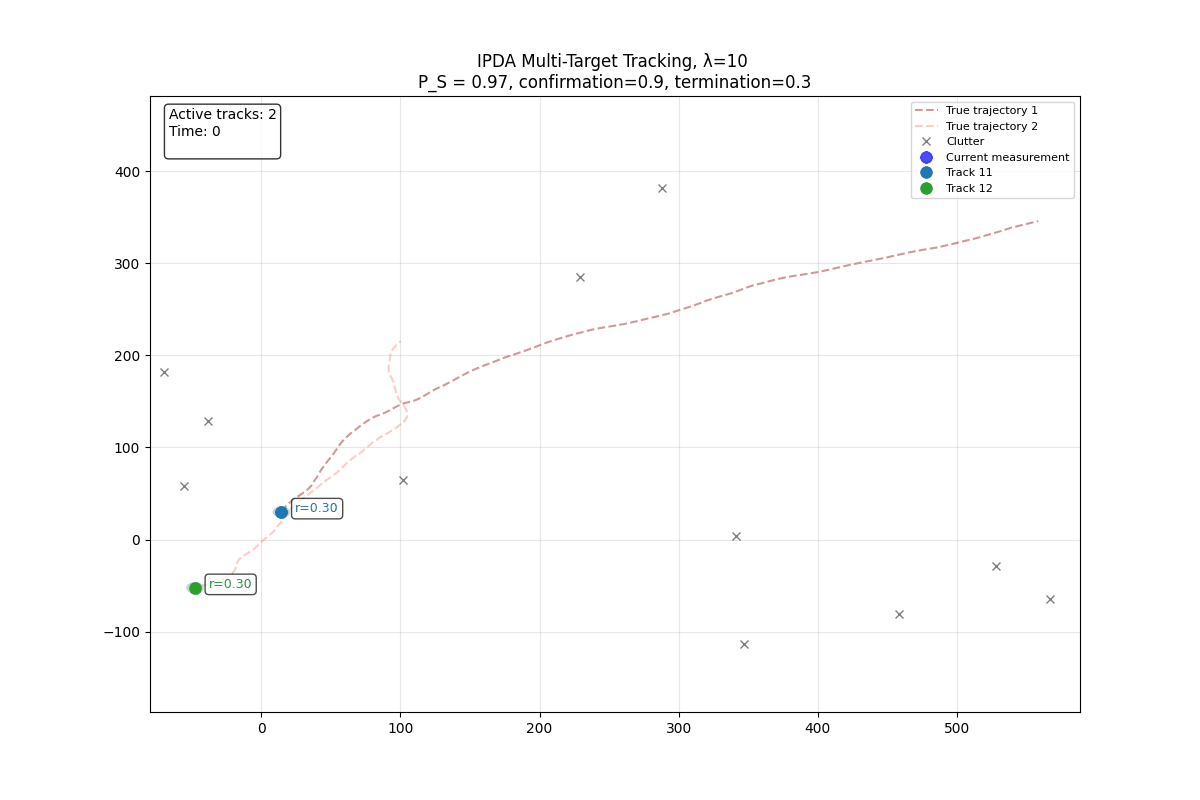

In [ ]:
# Simulation parameters
dt = 1.0
q = 0.5
r = 3.0
steps = 100
lambda_value = 10
Pd = 0.93
gamma = 9.0

P_S=0.97
r_0=0.3
confirm_threshold=0.9
delete_threshold=0.3
init_threshold=20
merge_threshold=5.0

# Create 3 targets with different initial states
targets_initial_states = [
    np.array([15., 30., 1., 1.]),    # Target 1
    np.array([-50., -50., -0.5, -0.5]) # Target 2
]

# Create simulation
x_targets, z_targets, A, H, Q, R = create_simulation(
    dt=dt, q=q, r=r,
    targets_initial_states=targets_initial_states,
    steps=steps
)

x_bounds, y_bounds = calculate_trajectory_bounds(x_targets, padding=30)

# Generate clutter in same area as trajectories
clutter = generate_clutter(
    lambda_value=lambda_value,
    x_min=x_bounds[0], x_max=x_bounds[1],
    y_min=y_bounds[0], y_max=y_bounds[1],
    steps=steps
)

missing_indices = simulate_detection_failures(z_targets, detection_probability = Pd, failure_intervals=[(70,73), (55,57)])
combined_z, _, missing_z_by_target = combine_measurements(z_targets, clutter, missing_indices)

# Initialize tracker
ipda_tracker = create_ipda_tracker(
    A=A, H=H, Q=Q, R=R, x_bounds=x_bounds, y_bounds=y_bounds,
    P_D=Pd, P_S=P_S, gamma=gamma,
    r_0=r_0, confirm_threshold=confirm_threshold,
    delete_threshold=delete_threshold, init_threshold=init_threshold,
    merge_threshold=merge_threshold)

# Set bounds
set_bounds(ipda_tracker, *x_bounds, *y_bounds)

# Process measurements
for k in range(steps):
    current_measurements = combined_z[k] if k < len(combined_z) else np.empty((0, 2))
    process_measurements_ipda(ipda_tracker, current_measurements, lambda_value)

# Get track histories
tracker_histories = get_track_histories_ipda(ipda_tracker)

# Run animation
animation_1 = animace_multi_target_tracker(
    z_combined=combined_z,
    clutter=clutter,
    x_targets=x_targets,
    tracker_histories=tracker_histories,
    filename="enhanced_tracking_1.gif",
    title=f"IPDA Multi-Target Tracking, λ={lambda_value} \nP_S = {P_S}, confirmation={confirm_threshold}, termination={delete_threshold}",
    vypadek_mereni = missing_z_by_target,
    fps=3,
    x_bounds=x_bounds,
    y_bounds=y_bounds
)

display(animation_1)